<a href="https://colab.research.google.com/github/talhaanwarch/my_pytorch/blob/master/tpu_multilabel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
#TPU
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!pip install pytorch-lightning
!pip install torchmetrics
!pip install onnx
!pip install onnxruntime


In [2]:
import  pytorch_lightning as pl
print(pl.__version__)

1.3.6


In [3]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [4]:
# !wget http://download.cs.stanford.edu/deep/CheXpert-v1.0-small.zip

In [5]:
# %%capture
# !unzip /content/CheXpert-v1.0-small.zip

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [7]:
train=pd.read_csv('/content/CheXpert-v1.0-small/train.csv')
train.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [8]:
val=pd.read_csv('/content/CheXpert-v1.0-small/valid.csv')
val.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/valid/patient64541/study1/...,Male,73,Frontal,AP,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CheXpert-v1.0-small/valid/patient64542/study1/...,Male,70,Frontal,PA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,CheXpert-v1.0-small/valid/patient64542/study1/...,Male,70,Lateral,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,CheXpert-v1.0-small/valid/patient64543/study1/...,Male,85,Frontal,AP,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CheXpert-v1.0-small/valid/patient64544/study1/...,Female,42,Frontal,AP,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:

import csv
def read_images(path):
  image_names = []
  labels = []
  policy='ones'
  with open(path, "r") as f:
      csvReader = csv.reader(f)
      next(csvReader, None)
      k=0
      for line in csvReader:
          k+=1
          image_name= line[0]
          label = line[5:]
          
          for i in range(14):
              if label[i]:
                  a = float(label[i])
                  if a == 1:
                      label[i] = 1
                  elif a == -1:
                      if policy == "ones":
                          label[i] = 1
                      elif policy == "zeroes":
                          label[i] = 0
                      else:
                          label[i] = 0
                  else:
                      label[i] = 0
              else:
                  label[i] = 0
                  
          image_names.append(image_name)
          labels.append(label)
  return image_names,labels

In [10]:
train_image,train_label=read_images('/content/CheXpert-v1.0-small/train.csv')
val_image,val_label=read_images('/content/CheXpert-v1.0-small/valid.csv')

In [11]:
class_names = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 
               'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 
               'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
print(len(class_names))

14


In [12]:
from pytorch_lightning import seed_everything, LightningModule, Trainer
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint
from torch.nn.functional import cross_entropy
from sklearn.utils import class_weight
from torchvision import transforms 
import torchvision.models as models
import torchmetrics
import torch#pytorch
from sklearn.utils import class_weight

In [13]:
aug=transforms.Compose([
                        transforms.Resize((224,224)),
                        #transforms.CenterCrop(224),
                        transforms.RandomHorizontalFlip(p=0.5),
                        transforms.RandomVerticalFlip(p=0.5),
                        transforms.RandomRotation(degrees=3),
                        transforms.RandomPerspective(0.05,0.2),
                        transforms.ToTensor(),
                        transforms.Normalize([0.5, ], [0.5,]),

                        ])

In [14]:
from PIL import Image
from torch.utils.data import DataLoader, Dataset
class DataReader(Dataset):
  def __init__(self,image,label,transform=None):
    super(DataReader,self).__init__()
    self.image=image
    self.label=label
    self.transform=transform

  def __len__(self):
    return len(self.image)

  def __getitem__(self,index):
    image_path=self.image[index]
    image_label=self.label[index]

    #read data
    image=Image.open(image_path).convert('L')

    if self.transform:
      image=self.transform(image)

    return image,torch.tensor(image_label,dtype=torch.float32)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  /pytorch/aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]


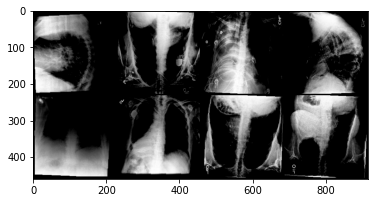

In [15]:
#code testing
from torch.utils.data.dataloader import DataLoader
import torchvision
import matplotlib.pyplot as plt
train=DataReader(np.array(train_image),np.array(train_label),transform=aug)
train_loader = DataLoader(train,shuffle=True,num_workers=0,batch_size=8)
batch,_=next(iter(train_loader))
grid_img=torchvision.utils.make_grid(batch,4,4)
plt.imshow(grid_img.permute(1, 2, 0),cmap='gray')

In [16]:
import torch
import torch.nn as nn
class Fire1(nn.Module):
   
    def __init__(self, in_channels, squeeze_channels,expand_channels):
        super(Fire1, self).__init__()

        # squeeze 
        self.squeeze = nn.Conv2d(in_channels, squeeze_channels, kernel_size=1)
        self.relu = nn.LeakyReLU()

        # expand
        self.expand_1x1 =nn.Conv2d(squeeze_channels, expand_channels, kernel_size=1)
        self.expand_3x3 =nn.Conv2d(squeeze_channels, expand_channels, kernel_size=3,padding=1)
        

    def forward(self, x):
        x = self.squeeze(x)
        x= self.relu(x)
        x = torch.cat([self.expand_1x1(x),self.expand_3x3(x)], dim=1)
        x = self.relu(x)
        return x
    
    
class MyModelV3(torch.nn.Module):
    
    def __init__(self):
        super(MyModelV3, self).__init__()
        self.net = torch.nn.Sequential(
                 nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3,stride=2),
                 nn.MaxPool2d(kernel_size=3,stride=2),
                 nn.LeakyReLU(),
                 nn.BatchNorm2d(32),
                 Fire1(in_channels=32, squeeze_channels=16,expand_channels=32),
                 Fire1(in_channels=64, squeeze_channels=16,expand_channels=64),
                 nn.MaxPool2d(kernel_size=3,stride=2),
                 #nn.BatchNorm2d(128),
                 Fire1(in_channels=128, squeeze_channels=32,expand_channels=96),
                 Fire1(in_channels=192, squeeze_channels=32,expand_channels=128),
                 nn.MaxPool2d(kernel_size=3,stride=2),
                 #nn.BatchNorm2d(256),
                 Fire1(256, 48, 160),
                 Fire1(320, 48, 160),
                 #nn.BatchNorm2d(320),
                 nn.Conv2d(in_channels=320,out_channels=128*2,kernel_size=1,stride=2),
                 nn.LeakyReLU(),
                 nn.Conv2d(in_channels=128*2,out_channels=32,kernel_size=1,stride=1),
                 nn.LeakyReLU(),
                 nn.Conv2d(in_channels=32,out_channels=16,kernel_size=1,stride=1),
                 nn.LeakyReLU(),#just for testing
                 #nn.Conv2d(in_channels=32,out_channels=16,kernel_size=1,stride=1),
                 nn.Flatten(),
                 #PrintShape(),
                 nn.Linear(784, 784//2),
                 nn.LeakyReLU(),
                 nn.Linear(784//2, 14),
                 nn.Sigmoid(),
                
               
                )        
    def forward(self, x):
        return self.net(x)    

In [17]:
x=torch.randn(1,1,224,224)
model=MyModelV3()
out=model(x)
out.shape

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([1, 14])

In [19]:
criterion=nn.BCEWithLogitsLoss()
criterion(out,torch.tensor(np.expand_dims(train_label[0],0),dtype=torch.float32))


tensor(0.9031, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

In [20]:
# pred=torch.tensor(np.expand_dims(train_label[0],0),dtype=torch.float32)
# pred.shape,out.shape


In [40]:
train_images=np.array(train_image)[0:1000]
train_labels=np.array(train_label)[0:1000]
val_images=np.array(val_image)[0:100]
val_labels=np.array(val_label)[0:100]

In [89]:
import torch.nn as nn
class OurModel(LightningModule):
  def __init__(self):
    super(OurModel,self).__init__()
    #architecute
    self.layer = MyModelV3()
   
  #parameters
    
    self.batch_size=256
    self.numworker=1
    self.criterion=nn.BCELoss()
    
  def forward(self,x):
    return self.layer(x)


  def configure_optimizers(self):
    optimizer=torch.optim.Adam(params=self.parameters(), lr = 0.0001, betas = (0.9, 0.999), eps = 1e-08, weight_decay = 0)
    lr_schedulers ={'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor =0.5,patience =2,verbose =True),
                    'monitor': 'val/loss'}
    return {"optimizer": optimizer, "scheduler": lr_schedulers}

  def train_dataloader(self):
    return DataLoader(DataReader(train_images,train_labels,aug), batch_size = self.batch_size, num_workers=self.numworker,shuffle=True)

  def training_step(self,batch,batch_idx):
    image,label=batch
    out=self(image)
    loss=self.criterion(out,label)

    self.log('train/loss', loss, on_epoch=True,prog_bar=True)
    return loss

  def val_dataloader(self):
    return DataLoader(DataReader(val_images,val_labels,aug), batch_size = self.batch_size,num_workers=self.numworker,  shuffle=False)
    
  def validation_step(self,batch,batch_idx):
    image,label=batch
    out=self(image)
    loss=self.criterion(out,label)
    self.log('val/loss', loss, on_epoch=True,prog_bar=True)
    return loss


  def test_dataloader(self):
    return DataLoader(DataReader(val_images,val_labels,aug), batch_size = self.batch_size,num_workers=self.numworker,  shuffle=False)
    
  def test_step(self,batch,batch_idx):
    image,label=batch
    out=self(image)
    loss=self.criterion(out,label)
    self.log('test/loss', loss, on_epoch=True,prog_bar=True)
    return loss




In [90]:
early_stop_callback = EarlyStopping(monitor='val/loss', min_delta=0.00, patience=2, verbose=True, mode='min')
checkpoint_callback = ModelCheckpoint(monitor='val/loss',dirpath='/content/drive/MyDrive/',
                                      filename='chestxray' )
model = OurModel()
trainer = Trainer(max_epochs=4, auto_lr_find=False, auto_scale_batch_size=False,
                  tpu_cores=8,precision=16,
                  #gpus=-1,
                  progress_bar_refresh_rate=30, 
                  callbacks=[early_stop_callback,checkpoint_callback]
                  )
#trainer.tune(model)
trainer.fit(model)

GPU available: False, used: False
TPU available: True, using: 8 TPU cores

  | Name      | Type      | Params
----------------------------------------
0 | layer     | MyModelV3 | 686 K 
1 | criterion | BCELoss   | 0     
----------------------------------------
686 K     Trainable params
0         Non-trainable params
686 K     Total params
1.372     Total estimated model params size (MB)


[rank: 0] Metric val/loss improved. New best score: 0.690
[rank: 4] Metric val/loss improved. New best score: 0.691
[rank: 1] Metric val/loss improved. New best score: 0.690
[rank: 7] Metric val/loss improved. New best score: 0.691
[rank: 5] Metric val/loss improved. New best score: 0.690
[rank: 3] Metric val/loss improved. New best score: 0.690
[rank: 2] Metric val/loss improved. New best score: 0.692
[rank: 6] Metric val/loss improved. New best score: 0.691


[rank: 7] Metric val/loss improved by 0.002 >= min_delta = 0.0. New best score: 0.690
[rank: 2] Metric val/loss improved by 0.002 >= min_delta = 0.0. New best score: 0.690
[rank: 6] Metric val/loss improved by 0.002 >= min_delta = 0.0. New best score: 0.689
[rank: 3] Metric val/loss improved by 0.002 >= min_delta = 0.0. New best score: 0.688
[rank: 1] Metric val/loss improved by 0.002 >= min_delta = 0.0. New best score: 0.688
[rank: 5] Metric val/loss improved by 0.002 >= min_delta = 0.0. New best score: 0.688
[rank: 0] Metric val/loss improved by 0.002 >= min_delta = 0.0. New best score: 0.688
[rank: 4] Metric val/loss improved by 0.002 >= min_delta = 0.0. New best score: 0.689


[rank: 6] Metric val/loss improved by 0.002 >= min_delta = 0.0. New best score: 0.687
[rank: 1] Metric val/loss improved by 0.002 >= min_delta = 0.0. New best score: 0.686
[rank: 0] Metric val/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.687
[rank: 2] Metric val/loss improved by 0.002 >= min_delta = 0.0. New best score: 0.688
[rank: 4] Metric val/loss improved by 0.002 >= min_delta = 0.0. New best score: 0.687
[rank: 7] Metric val/loss improved by 0.002 >= min_delta = 0.0. New best score: 0.688
[rank: 5] Metric val/loss improved by 0.002 >= min_delta = 0.0. New best score: 0.687
[rank: 3] Metric val/loss improved by 0.002 >= min_delta = 0.0. New best score: 0.687


[rank: 5] Metric val/loss improved by 0.002 >= min_delta = 0.0. New best score: 0.685
[rank: 3] Metric val/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.685
[rank: 6] Metric val/loss improved by 0.002 >= min_delta = 0.0. New best score: 0.686
[rank: 2] Metric val/loss improved by 0.002 >= min_delta = 0.0. New best score: 0.687
[rank: 7] Metric val/loss improved by 0.002 >= min_delta = 0.0. New best score: 0.687
[rank: 1] Metric val/loss improved by 0.002 >= min_delta = 0.0. New best score: 0.685
[rank: 4] Metric val/loss improved by 0.002 >= min_delta = 0.0. New best score: 0.685
[rank: 0] Metric val/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.685


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: cleaning up ddp environment...
  warnings.warn(*args, **kwargs)


In [66]:
# torch.save(model.state_dict(), '/content/drive/MyDrive/chest_state.pt')

In [91]:
trainer.test(model)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/loss': 0.68359375}
--------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: cleaning up ddp environment...
  warnings.warn(*args, **kwargs)


[{'test/loss': 0.68359375}]

In [ ]:
plt.figure(figsize=(14,10))
score=[]
for i in range(14):
    fpr, tpr, threshold = roc_curve(labels[:,i], preds[:,i])
    roc_auc = auc(fpr, tpr)
    score.append(roc_auc)


In [ ]:
np.mean(score)

In [ ]:
%%capture
!pip install onnx
!pip install onnxruntime

In [ ]:
filepath = '/content/drive/MyDrive/chestmodel.onnx'
input_sample = torch.randn((1,1, 224,224))
model.to_onnx(filepath,input_sample, export_params=True)

In [ ]:
import onnx
onnx_model = onnx.load(filepath)
onnx.checker.check_model(onnx_model)

In [ ]:
class OurModel(LightningModule):
  def __init__(self):
    super(OurModel,self).__init__()
    self.layer = MyModelV3()
  def forward(self,x):
    return self.layer(x)

  def train_dataloader(self):
    return DataLoader(DataReader(train_df))

  def training_step(self,batch,batch_idx):
    return loss

  def test_dataloader(self):
    return DataLoader(DataReader(test_df))
    
  def test_step(self,batch,batch_idx):
    image,label=batch
    out=self(image)
    loss=self.criterion(out,label)
    return loss

  def predict(self, batch, batch_idx: int , dataloader_idx: int = None):
        return self(batch)  
  